# MDA y PCA
## RMSD, coordenadas y volumen

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import csv
import ast
import datetime
import matplotlib.pyplot as plt
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
import glob, sys, os
sys.path.append(r'..')

In [2]:
from modules.MDS import cMDS
from modules.plotting_functions import plot_points, plot_anotation_labels

### Tabla de datos con las 402 estructuras

In [3]:
prot_name = 'cdk2'

In [4]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[8, 5]","[[40, 47], [295, 299]]",0,[],None,NaN
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[9, 12]","[[36, 44], [153, 164]]",2,"[EDO, PVB]",PVB,214.0


### Carga de las 402 estructuras

In [5]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = (os.path.join('..', '..', 'ARCHIVOS', 'CRISTALES', 'TRAJ_CRISTALS_PDB',
                        F'PDB_402_cdk2_PISANI_ALL.pdb'))
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


### Etiquetado de las estructuras según su conformación

In [6]:
# Esta función permite etiquetar las estructuras de la proteína CDK2
from modules.label_cdk2_confs import label_cdk2_conformations

In [7]:
# Función para etiquetar cada estructura
labels_cdk2 = label_cdk2_conformations(traj_crystals)
df_prot["Labels_conf"] = labels_cdk2
df_prot.iloc[:, -10:].head(5)

,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
1aq1,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0,inact_b
1b38,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0,inact_a
1b39,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0,inact_a
1buh,298,96.308725,2,"[8, 5]","[[40, 47], [295, 299]]",0,[],None,NaN,inact_a
1ckp,298,93.624161,2,"[9, 12]","[[36, 44], [153, 164]]",2,"[EDO, PVB]",PVB,214.0,inact_a


### Guardamos una nueva tabla con las etiquetas
**Guardamos un archivo _json_ para su posterior uso**

In [8]:
file_df_prot_confLabels = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json')))[0]
if False: # Activar para guardar
    df_cdk2.to_json(file_df_prot_confLabels)

### Subsecuencias de la proteína

In [9]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")

&nbsp; 
## Filtrado de las estructuras usadas por Pisani (2016)
Existen **tres filtros** que debemos aplicar para tratar de seleccionar las mismas 255 estructuras de Pisiani. Dos de estos filtros los dan los autores:
- Todas las estructuras cuyo valor de **resolución sea menor o igual a 2.5 A**
- Todas las estructuras que **NO** carezcan de *ninguno* de los residuos que mencionan en su lista (residuos de Pisani).

Para aplicar el segundo filtro es necesaria la siguiente función:

In [10]:
# Filtrado de las estructuras
# Primera condición
res_25_A_o_menos = df_prot.Resolution <= 2.5

# Segunda condición
from modules.find_gaps import is_a_gap
no_gaps_en_seq = df_prot.GapPos.apply( lambda x: is_a_gap(x, get_pisani_residues(x="list")) )

# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_prot.Date.apply(lambda x:  x.year  <= 2015)

# Obtenemos los índices resultantes
frames_pisani = np.array((res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos))

#### Guardamos los indices de los frames que pertenecen a las estructuras usadas por Pisani

In [11]:
# guardamos los indices correspondientes a los frames de pisani
file_pisani_frames = (os.path.join('..', 'data', '255_frames_pisani_2016'))
np.save(file_pisani_frames, frames_pisani)

&nbsp;
## Classical Multidimentional Scaling
### Matriz de disimilitud
#### RMSD alineando por residuos usados por Pisani
Utilizamos *pytraj* para generar la matrix de disimilitud con la métrica *RMSD* en las **255** estructuras usadas por Pisani.

In [12]:
# Máscara indicando los CA de los residuos de Pisani
pisani_mask = F"(:{pisiani_residues})&(@CA)"

# RMSD por pares de las 402 estructuras
pair_rmsd_402_struc = pyt.pairwise_rmsd( traj = traj_crystals, mask= pisani_mask, metric="rms")

# Subset de RMSD por pares usando sólo sus 255 estructuras
pair_rmsd_pisani = pair_rmsd_402_struc[:, frames_pisani][frames_pisani, :]

### Matrices distancia (RMSD)

In [13]:
import seaborn as sns
sns.set(context = 'talk', style = 'white')

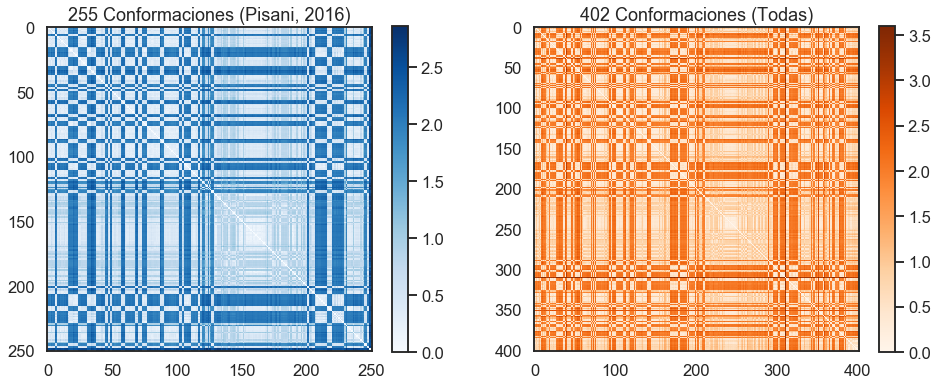

In [15]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 20})
plt.subplot(1, 2, 1)
plt.title("255 Conformaciones (Pisani, 2016)")
plt.imshow(pair_rmsd_pisani, zorder=2, cmap='Blues')
plt.colorbar();

plt.subplot(1, 2, 2)
plt.title("402 Conformaciones (Todas)")
plt.imshow(pair_rmsd_402_struc, zorder=2, cmap='Oranges', interpolation='nearest')
plt.colorbar();

### Generación del cMDS
#### Ensamble de 255 estructuras cristalográficas de CDK2
Vamos a crear un ensamble con las 255 estructuras, a partir de los CA de las cadenas A de cada proteína. Al leer cada estructura sólo se tomarán en cuenta los CA, y para el análisis de RMSD y MSD sólo los residuos definidos por Pisani.

In [16]:
# MDS, usamos la función que previamente habíamos definido en moduloes.cMDS
# MDS con los 255 Frames de Pisani
mds_pisani = cMDS(pair_rmsd_pisani)

# MDS con las 402 conformaciones
mds_total = cMDS(pair_rmsd_402_struc)

#### Estructuras de referencia

In [17]:
# Estructuras de  referencia que queremos mostrar en la gráfica
# Éstas son las estructuras que Pisani usa como referencia
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}

#### Gráfica de MDS de Pisani (2016)

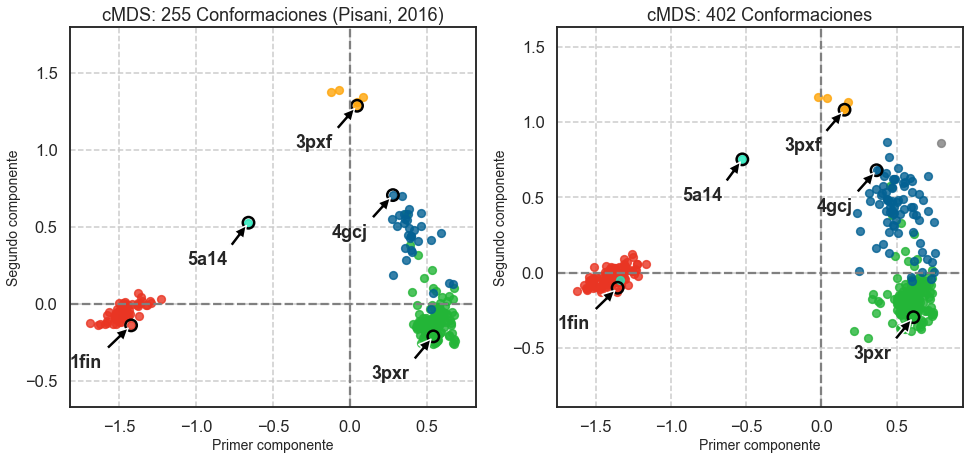

In [79]:
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_prot.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_points(mds = mds_pisani[0], labels = df_prot.Labels_conf[frames_pisani], alpha=0.8,
                             title = "cMDS: 255 Conformaciones (Pisani, 2016)")
plot_anotation_labels(df_prot.index[frames_pisani],  ref_structs_dict.keys(), 
                      mds_pisani[0][0], mds_pisani[0][1], xytext_delta=[0.4, 0.3], s=130)
 
plt.subplot(1, 2, 2)
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

# Proyección con Bokeh

In [195]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import Span

In [117]:
conformation_labels.unique()

array(['inact_b', 'inact_a', 'active', 'undefined', 'inact_ope',
       'dfg_out'], dtype=object)

In [239]:
colors_list = [ '#036193', '#23B537', '#E93523','gray', '#FEA50A', '#23E9BC']
conformation_labels = df_prot.Labels_conf
conf_labels = conformation_labels.unique()
# Creamos el diccionario con los colores correspondientes
code_labels = dict(zip(conf_labels, colors_list[:len(conf_labels)]))
# Creamos la lista de colores
color_labels = [ code_labels[i] for i in conformation_labels]

# Datasource
source_mds = ColumnDataSource(data = dict(
    x = mds_total[0][0],
    y = mds_total[0][1],
    pdb_id = df_prot.index.to_series().apply(lambda x: x.upper()),
    conf_label = conformation_labels,
    color_labels = color_labels,
))

In [268]:
TOOLS = "hover,wheel_zoom,zoom_in,zoom_out,box_zoom,"
TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("PDB ID", "@pdb_id"),
    ("conf", "@conf_label"),
]
m = figure(tools=TOOLS,  match_aspect = True, 
           tooltips = TOOLTIPS,  title = "cMDS: 402 Conformaciones")
m.scatter('x','y', source = source_mds,
          size = 10, legend = 'conf_label',
          fill_color='color_labels', fill_alpha=0.6,
          line_color=None)
# Vertical line
vline = Span(location=0, dimension='height', line_color='grey', line_width=3, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', line_color='grey', line_width=3, line_dash='dashed')
m.renderers.extend([vline, hline])

In [273]:
output_notebook()
show(m)

Loading BokehJS ...

### Plot RMSD vs primer frame

In [34]:
# Cálculo del RMSD contra el primer frame (estructura 1aq1)
rmsd_frame_1 = pyt.rmsd(traj_crystals, mask=pisani_mask, ref=0, nofit = False, update_coordinate=False)

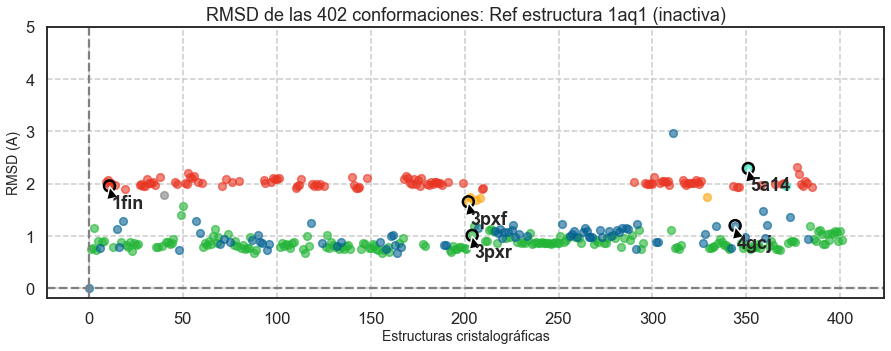

In [46]:
fig = plt.figure(figsize=(15, 5))

rmsd_plot = np.array([range(len(df_prot.Labels_conf)), rmsd_frame_1])

plot_points(rmsd_plot, labels = df_prot.Labels_conf, equal_axis=False,
                xlabel = "Estructuras cristalográficas", ylabel = "RMSD (A)", 
                title = "RMSD de las 402 conformaciones: Ref estructura 1aq1 (inactiva)")
plot_anotation_labels(df_prot.index, ref_structs_dict.keys(), 
                      rmsd_plot[0], rmsd_plot[1], xytext_delta=[-1, 0.5], s=120)
plt.ylim(top=5);

### Plot de RMSD vs el frame promedio

In [39]:
# Estructura promedio
avg_frame = pyt.mean_structure(traj_crystals)
# Cálculo del RMSD contra el frame promedio
rmsd_avg_frame = pyt.rmsd(traj_crystals, mask=pisani_mask, ref=avg_frame, 
                        nofit = False, update_coordinate=False)

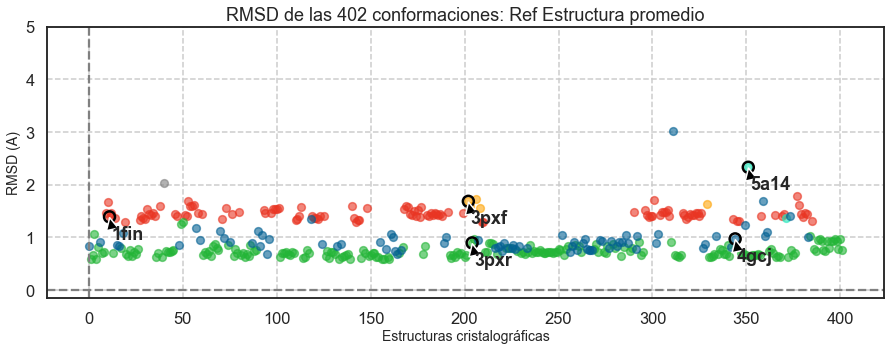

In [45]:
fig = plt.figure(figsize=(15, 5))

rmsd_plot = np.array([range(len(df_prot.Labels_conf)), rmsd_avg_frame])

plot_points(rmsd_plot, labels = df_prot.Labels_conf, equal_axis=False,
                xlabel = "Estructuras cristalográficas", ylabel = "RMSD (A)", 
                title = "RMSD de las 402 conformaciones: Ref Estructura promedio")
plot_anotation_labels(df_prot.index, ref_structs_dict.keys(), 
                      rmsd_plot[0], rmsd_plot[1], xytext_delta=[-1, 0.5], s=120)
plt.ylim(top=5);

&nbsp;
## Dimensionality Reduction

Se utilizan diferentes métodos de reducción dimensional a modo de prueba. No obstante, al ser un método no supervisado por ahora sólo nos enfocamos es la separación de las conformaciones según su etiqueta de actividad. En un posterior notebook se evaluará la aplicación de estos métodos para separar conformaciones según otro algun criterio.

> #### NOTA:
- **Diferentes subsecuencias son evaluadas.**
- **Para cada subsecuencia evaluada la estructura es alineada previemente según dicha subsecuecia.**

### Se crean las instancias de los estimadores

In [78]:
from copy import copy
# Necesario para duplicar las instancias de los estimadores de sklearn

#### Objeto PCA

In [57]:
# Instancia de PCA
from sklearn.decomposition import PCA
pca_obj = PCA(n_components= 2)

#### Objeto Kernel PCA

In [144]:
from sklearn.decomposition import KernelPCA
k_pca_obj = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)

#### Objeto LLE (Locally Linear Embeding)
Método de reducción dimensional no linear. funciona estimando la relación lineal entre las instancias cercanas y luego busca un nuevo espacio no lineal que preserve al máximo  dicha relación local.

In [150]:
# Instancia de LLE (Locally Linear Embeding)
from sklearn.manifold import LocallyLinearEmbedding
lle_obj = LocallyLinearEmbedding(n_components= 2, n_neighbors=25)

#### Objeto t-SNE (t-Distributed Stochastic Neighbor Embeding)
Método de reducción dimensional que busca mantener cerca las instancias similares maximizando la distancia entre las instancias disimiles. [Más sobre el método (Pendiente en directorio Misceláneos)](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)

In [59]:
# Instancia de t-SNE (t-Distributed Stochastic Neighbor Embedding)
from sklearn.manifold import TSNE
t_sne_obj = TSNE(n_components = 2)

### Función para ejecutar el método de reducción dimensional
- Definimos la función `get_pca()` que recibe una instancia de `PCA()`, o algún otro estimador de reducción dimensional y devuelve el estimador entrenado con la treyectoria indicada según la máscara y los frames señalados.

In [79]:
def get_new_dimentions(dmr_obj, traj, frames = None, atom_mask = "@CA"):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    if frames is None:
        frames = range(0, traj.n_frames)
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    # Crea una copia del estimador para evitar reentrenar el mismo objeto
    dmr_obj_copy = copy(dmr_obj)
    reduced = dmr_obj_copy.fit_transform( xyz_2d_array )
    return reduced

- **Reducción Dimensional con todos los residuos:**

In [152]:
# Alineamiento
pyt.align(traj_crystals, "@CA")
# PCA
pca_pyt_all = get_new_dimentions(pca_obj, traj_crystals, frames_pisani, "@CA")
# kernelPCA
k_pca_pyt_all = get_new_dimentions(k_pca_obj, traj_crystals, frames_pisani, "@CA")
# LLE
lle_pyt_all = get_new_dimentions(lle_obj, traj_crystals, frames_pisani, "@CA")
# tSNE
tsne_pyt_all = get_new_dimentions(t_sne_obj, traj_crystals, frames_pisani, "@CA")

- **Reducción Dimensional con subsecuencia de Pisani:**

In [153]:
# Carbonos alfa de la subsecuencia de Pisani
mask = F"(:{pisiani_residues})&(@CA)"
pyt.align(traj_crystals, mask)
# PCA
pca_pyt_pisani  = get_new_dimentions(pca_obj, traj_crystals, frames_pisani, mask)
# kernel PCA
k_pca_pyt_pisani  = get_new_dimentions(k_pca_obj, traj_crystals, frames_pisani, mask)
# LLE
lle_pyt_pisani = get_new_dimentions(lle_obj, traj_crystals, frames_pisani, mask)
# tSNE
tsne_pyt_pisani = get_new_dimentions(t_sne_obj, traj_crystals, frames_pisani, mask)

- **Reducción Dimensional con la subsecuencia del _sitio activo_ (todos los $C\alpha$ del sitio activo)**

In [154]:
# Usando todos los carbonos alfa del pocket
mask = F"(:{pocket_residues})&(@CA)"
pyt.align(traj_crystals, mask)
# PCA
pca_pyt_pocket =get_new_dimentions(pca_obj, traj_crystals, frames_pisani, mask)
# kernel PCA
k_pca_pyt_pocket =get_new_dimentions(k_pca_obj, traj_crystals, frames_pisani, mask)
# LLE
lle_pyt_pocket = get_new_dimentions(lle_obj, traj_crystals, frames_pisani, mask)
# tSNE
tsne_pyt_pocket = get_new_dimentions(t_sne_obj, traj_crystals, frames_pisani, mask)

- **Reducción Dimensional con la subsecuencia del _sitio activo_ (sólo $C\alpha$ de las estructuras secundarias)**  
Antes de hacer el análisis se determina que parte de la subsecuencia del sitio activo corresponde a regiones con estructura secundaria.

In [186]:
# Los índices indican [1] secuencia sec. en string, y [0] = frame 1
sec_secundaria_cdk2_f1 = pyt.dssp_analysis.dssp(traj_crystals, "@CA")[1][0]
# Obtenemos los residuos del pocket
struct_pocket = sec_secundaria_cdk2_f1[get_pocket_residues("list")]
# Cremos la lista de índices
secondary_pk_index = [ j for i, j in zip(struct_pocket, get_pocket_residues("list")) if i != '0' ]
secondary_pk_index_string = ",".join([str(i) for i in secondary_pk_index])

In [187]:
# Usando todos los carbonos alfa del pocket
mask = F"(:{secondary_pk_index_string})&(@CA)"
pyt.align(traj_crystals, mask)
# PCA
pca_pyt_pocket_sec = get_new_dimentions(pca_obj, traj_crystals, frames_pisani, mask)
# kernel PCA
k_pca_pyt_pocket_sec = get_new_dimentions(k_pca_obj, traj_crystals, frames_pisani, mask)
# LEE
lle_pyt_pocket_sec = get_new_dimentions(lle_obj, traj_crystals, frames_pisani, mask)
# tSNE
tsne_pyt_pocket_sec = get_new_dimentions(t_sne_obj, traj_crystals, frames_pisani, mask)

&nbsp;
## Gráficas *Dimensionality Reduction* con 255 estructuras de Pisani
Las siguientes graficas evaluan las 255 estructuras utilizadas por Pisani.

In [130]:
def plot_pca_pisani_structs(models, titles = ["Todos los átomos", "subsec. de Pisani", "Subsec. del Sitio Activo",
                                    "Estruc. Secundaria del Sitio Activo"]):
    for i, model in enumerate(models):
        plt.subplot(1, 4, i + 1)
        plot_points(mds = model.T, labels = df_prot[frames_pisani].Labels_conf,
                                     title = titles[i])
        plot_anotation_labels(df_prot[frames_pisani].index, ref_structs_dict.keys(), 
                              model[:,0], model[:,1], xytext_delta=[-0.0, 0.0], s=120)

### Principal Component Analysis

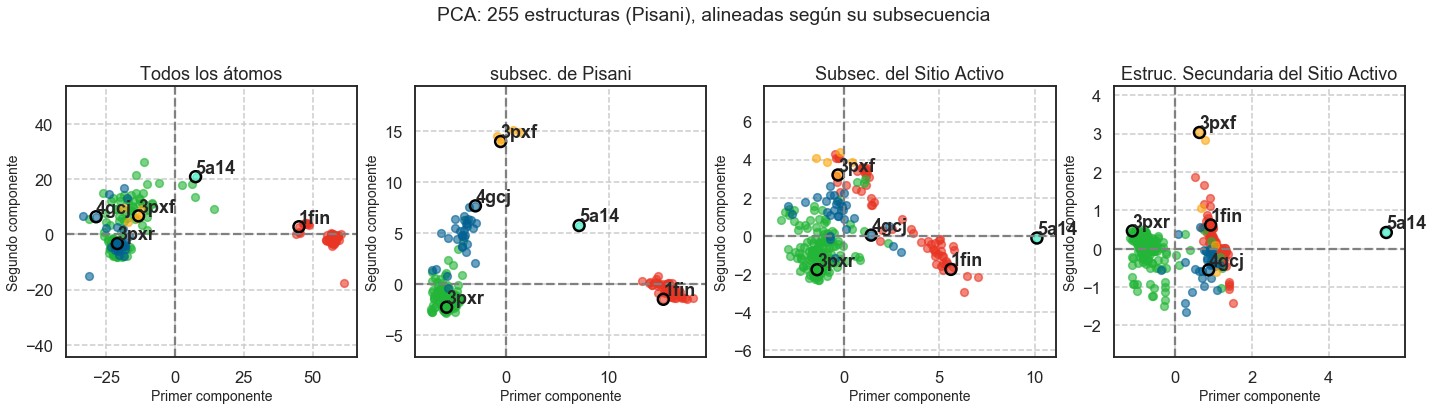

In [159]:
fig = plt.figure(figsize=(24, 5))

pca_models = [pca_pyt_all, pca_pyt_pisani, pca_pyt_pocket, pca_pyt_pocket_sec]
plot_pca_pisani_structs(pca_models)
plt.suptitle("PCA: 255 estructuras (Pisani), alineadas según su subsecuencia", y = 1.1);

### Kernel PCA

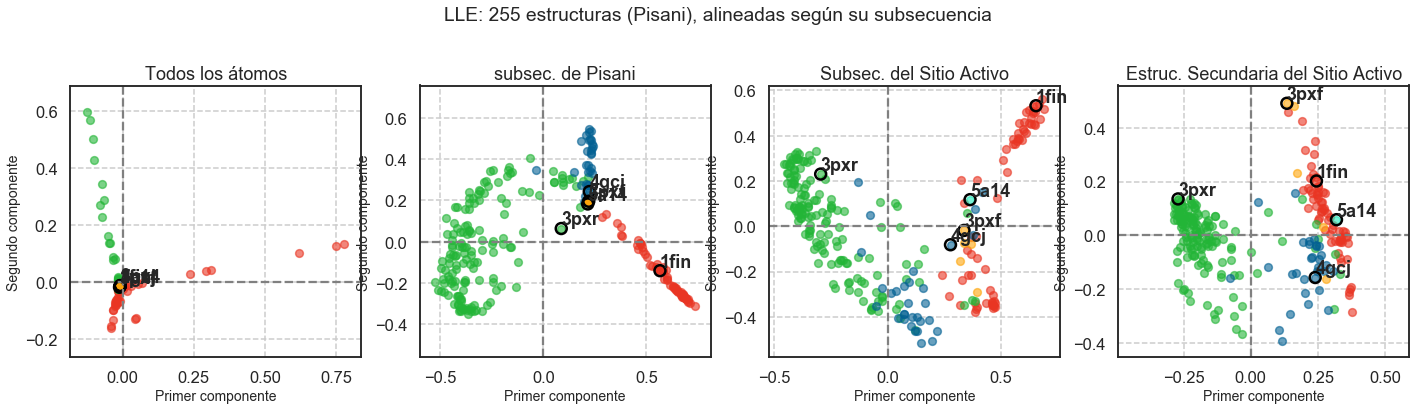

In [160]:
fig = plt.figure(figsize=(24, 5))

k_pca_models = [k_pca_pyt_all, k_pca_pyt_pisani, k_pca_pyt_pocket, k_pca_pyt_pocket_sec]
plot_pca_pisani_structs(k_pca_models)
plt.suptitle("LLE: 255 estructuras (Pisani), alineadas según su subsecuencia", y = 1.1);

### LLE: Locally-linear Embedding

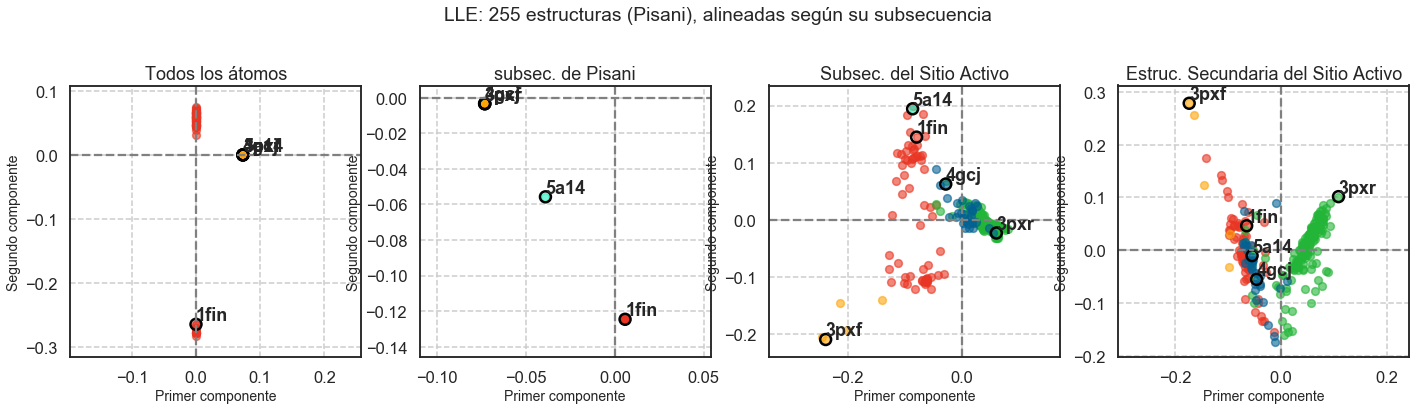

In [167]:
fig = plt.figure(figsize=(24, 5))

lle_models = [lle_pyt_all, lle_pyt_pisani, lle_pyt_pocket, lle_pyt_pocket_sec]
plot_pca_pisani_structs(lle_models)
plt.suptitle("LLE: 255 estructuras (Pisani), alineadas según su subsecuencia", y = 1.1);

### t-SNE: t-Distributed Stochastic Neighbor Embedding

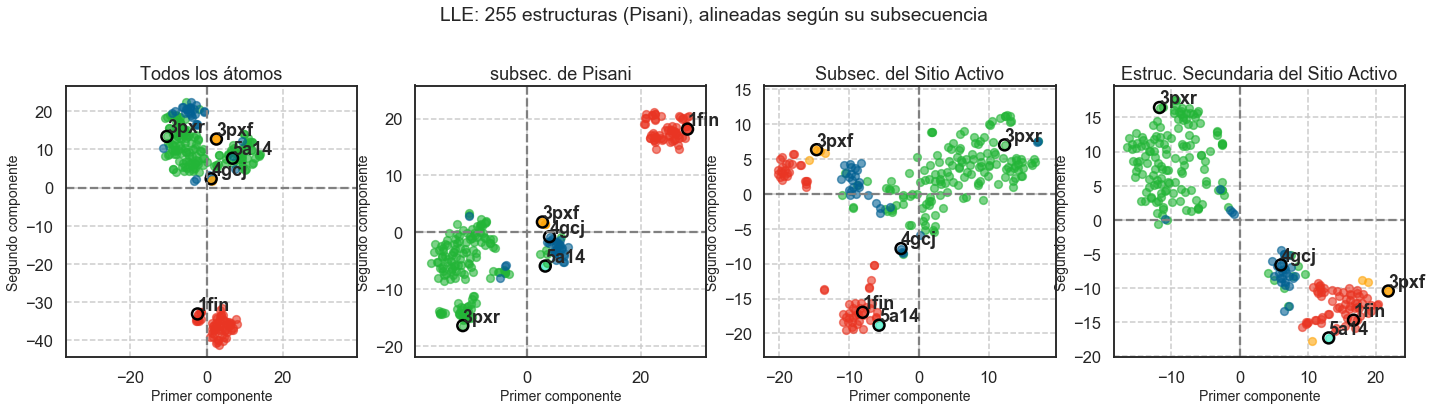

In [166]:
fig = plt.figure(figsize=(24, 5))

tsne_models = [tsne_pyt_all, tsne_pyt_pisani, tsne_pyt_pocket, tsne_pyt_pocket_sec]
plot_pca_pisani_structs(tsne_models)
plt.suptitle("LLE: 255 estructuras (Pisani), alineadas según su subsecuencia", y = 1.1);

#### Diferentes subsets para el PCA a partir del mismo subset de alineamiento
Las gráficas de abajo evalúan  cómo cambian los resultados cuando **las estructuras son superpuestas utilizando un _subset_ de átomos** (por ejemplo las estructuras secundarias de Pisani) pero el **PCA es generado usando otro _subset_** de átomos.

In [181]:
def get_dmr_given_a_unique_alignment(traj, dmr_obj, mask_align, mask_dmr = None):
    '''
    Realiza la reducción dimensional (DMR) de una trayectoria dado una maáscara de alineamiento
    y una lista de máscaras con los átomos a considerar para la DMR.
    '''
    # Realiza el alineamiento con mask_align
    temp_traj = traj.copy()
    pyt.align(traj, mask_align)
    # Realiza la reducción dimensional con mask_dmr, sin realinear las estructuras
    dmr_dic = {}
    for name, mask in mask_dmr.items():
        dmr_dic[name] = get_new_dimentions(dmr_obj, temp_traj, frames_pisani, mask)
    return(dmr_dic)

### Alineadas por todos los residuos

In [188]:
mask_dic = {'Todos los átomos': "@CA", 'subsec. Pisani': F"(:{pisiani_residues})&(@CA)", 
            'subsec. Sitio Activo': F"(:{pocket_residues})&(@CA)", 
            'Estrc. Sec. Sitio Activo':  F"(:{secondary_pk_index_string})&(@CA)"}

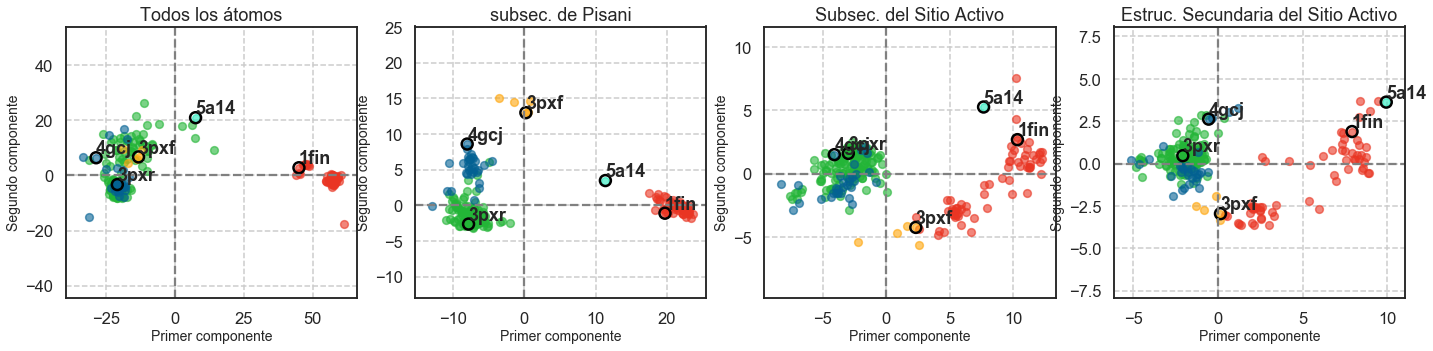

In [195]:
fig = plt.figure(figsize=(24, 5))
x = get_dmr_given_a_unique_alignment(traj_crystals, pca_obj, mask_dic['Todos los átomos'], mask_dic)
plot_pca_pisani_structs(x.values())

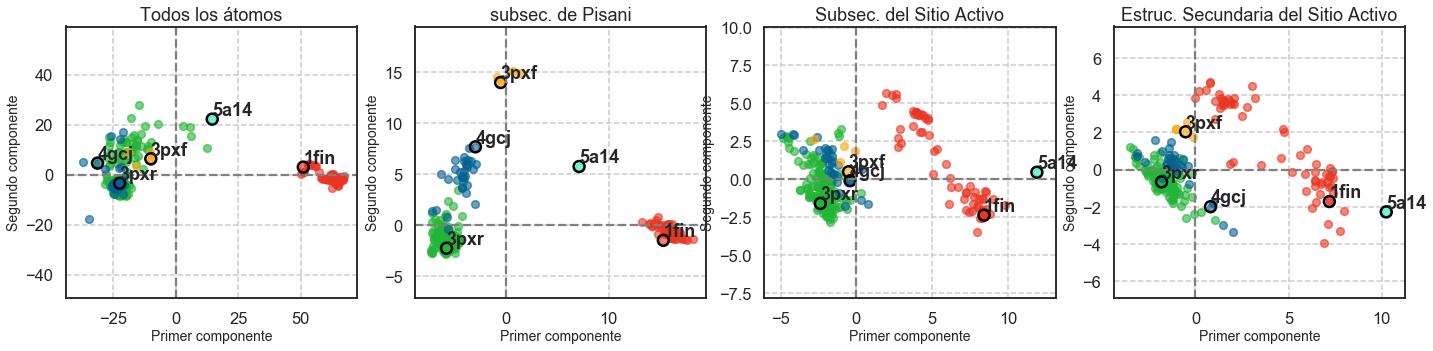

In [196]:
fig = plt.figure(figsize=(24, 5))
x = get_dmr_given_a_unique_alignment(traj_crystals, pca_obj, mask_dic['subsec. Pisani'], mask_dic)
plot_pca_pisani_structs(x.values())

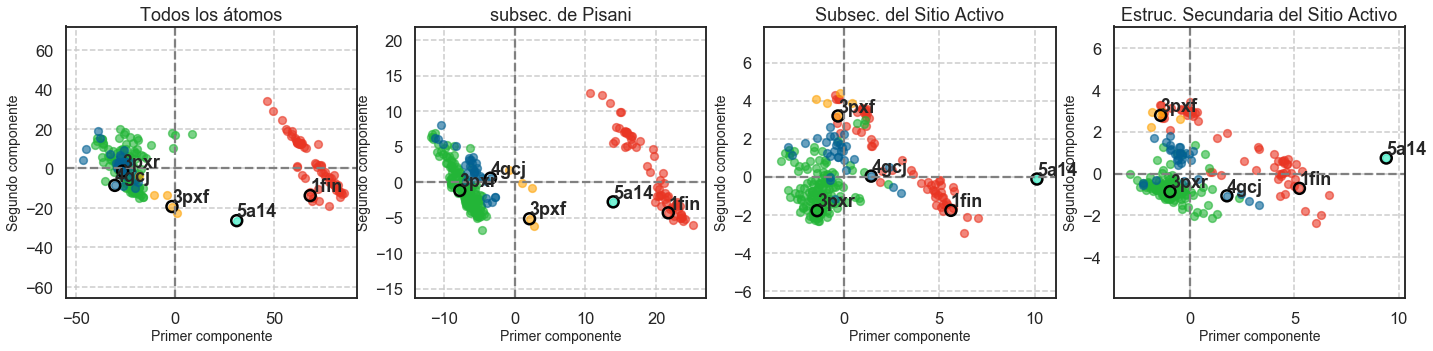

In [197]:
fig = plt.figure(figsize=(24, 5))
x = get_dmr_given_a_unique_alignment(traj_crystals, pca_obj, mask_dic['subsec. Sitio Activo'], mask_dic)
plot_pca_pisani_structs(x.values())

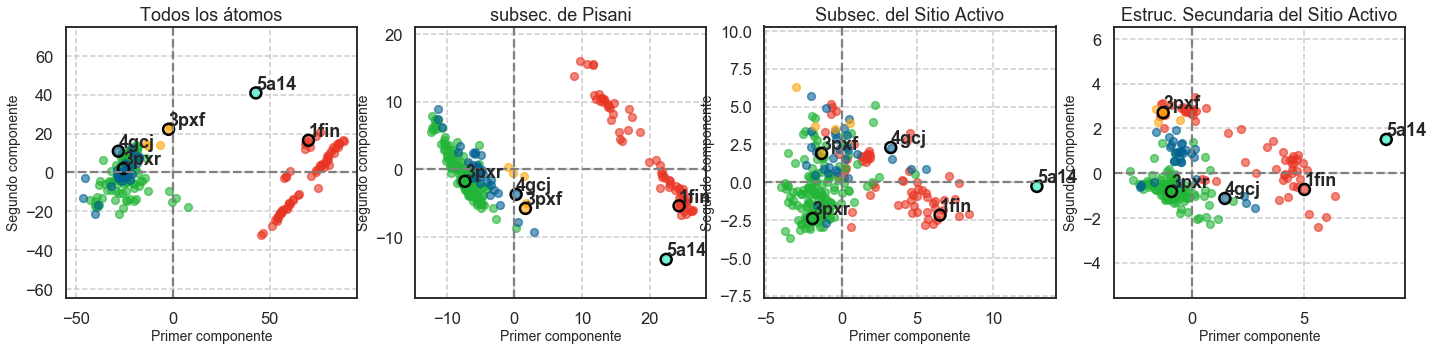

In [198]:
fig = plt.figure(figsize=(24, 5))
x = get_dmr_given_a_unique_alignment(traj_crystals, pca_obj, mask_dic['Estrc. Sec. Sitio Activo'], mask_dic)
plot_pca_pisani_structs(x.values())